In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as svm
import seaborn as sn
import copy

In [14]:
# Read data
data = pd.read_csv("breast_cancer.csv")

In [15]:
# Split data into test and train
train_data = data[:500]
test_data = data[500:]

In [16]:
# Split labels and features in the dataset
train_X = train_data.drop(labels='Class', axis=1).to_numpy()
train_y = train_data['Class'].to_numpy()

test_X = test_data.drop(labels='Class', axis=1).to_numpy()
test_y = test_data['Class'].to_numpy()

In [17]:
def analyze_model(model, test_data, title=""):

    features = test_data[:,:8]
    labels = test_data[:,8]

    # Calculate predictions
    predictions = model.predict(features)

    # Calculate the prediction situation
    prediction_situation = predictions == labels

    # Find the number of false, true and total number of predictions
    num_false_predictions = np.count_nonzero(prediction_situation == False)
    num_true_predictions = np.count_nonzero(prediction_situation == True)
    num_predictions = len(prediction_situation)

    # Calculate true tumor, false tumor, true malignant, false malignant values
    tumor_labels = labels == 1
    true_tumor_predictions = tumor_labels & prediction_situation

    num_true_tumor_predictions = np.count_nonzero(true_tumor_predictions == True)
    num_true_malignant_predictions = num_true_predictions - num_true_tumor_predictions

    num_false_tumor_predictions = np.count_nonzero(predictions == 1) - num_true_tumor_predictions
    num_false_malignant_predictions = num_false_predictions - num_false_tumor_predictions

    # Calculate and report performance metrics
    metrics = calculateMetrics(num_true_tumor_predictions, num_false_tumor_predictions, num_true_malignant_predictions, num_false_malignant_predictions)
    print("Accuracy is:", metrics['accuracy'])
    print("Precision is:", metrics['normal'][0])
    print("Recall is:", metrics['normal'][1])
    print("F1 Score is:", metrics['normal'][2])
    print("F2 Score is:", metrics['normal'][3])

    # Plot confusion matrix
    confusion_matrix = [[num_true_tumor_predictions, num_false_malignant_predictions],
                    [num_false_tumor_predictions, num_true_malignant_predictions]]

    df_confusion_matrix = pd.DataFrame(confusion_matrix, ['Tumor', 'Malignant'], ['Tumor', 'Malignant'])
    sn.set(font_scale=1.4)
    sn.heatmap(df_confusion_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    title = "Confusion Matrix for " + title
    plt.title(title)
    plt.show()

In [18]:
def calculateMetrics(true_tumor, false_tumor, true_malignant, false_malignant):

    metrics = dict()

    accuracy = (true_tumor + true_malignant) / (true_tumor + false_tumor + true_malignant + false_malignant)
    metrics['accuracy'] = accuracy


    precision = true_tumor / (true_tumor + false_tumor)
    recall = true_tumor / (true_tumor + false_malignant)
    f1_score = (2 * precision * recall) / (precision + recall)
    f2_score = (5 * precision * recall) / ((4 * precision) + recall)
    metrics['normal'] = [precision, recall, f1_score, f2_score]

    """
    # Micro
    precision = (true_tumor + true_malignant) / (true_tumor + false_tumor + true_malignant + false_malignant)
    recall = (true_tumor + true_malignant) / (true_tumor + false_malignant + true_malignant + false_tumor)
    negative_predictive_value = (true_malignant + true_tumor) / (true_malignant + false_malignant + true_tumor + false_tumor)
    false_positive_rate = (false_tumor + false_malignant) / (false_tumor  + true_malignant + false_malignant + true_tumor)
    false_discovery_rate = (false_tumor + false_malignant) / (false_tumor + true_tumor + false_malignant + true_malignant)
    f1_score = (2 * precision * recall) / (precision + recall)
    f2_score = (5 * precision * recall) / ((4 * precision) + recall)

    metrics['micro'] = [precision, recall, negative_predictive_value, false_positive_rate, false_discovery_rate, f1_score, f2_score]


    # Macro
    precision_tumor = (true_tumor / (true_tumor + false_tumor))
    precision_malignant = (true_malignant / (true_malignant + false_malignant))
    precision = (precision_tumor + precision_malignant) / 2

    recall_tumor = true_tumor / (true_tumor + false_malignant)
    recall_malignant = true_malignant / (true_malignant + false_tumor)
    recall = (recall_tumor + recall_malignant) / 2

    negative_predictive_value = ((true_malignant / (true_malignant + false_malignant)) + (true_tumor / (true_tumor + false_tumor))) / 2

    false_positive_rate = ((false_tumor / (false_tumor + true_malignant)) + (false_malignant / (false_malignant + true_tumor))) / 2

    false_discovery_rate = ((false_tumor / (false_tumor + true_tumor)) + (false_malignant / (false_malignant + true_malignant))) / 2

    f1_score_tumor = (2 * precision_tumor * recall_tumor) / (precision_tumor + recall_tumor)
    f1_score_malignant = (2 * precision_malignant * recall_malignant) / (precision_malignant + recall_malignant)
    f1_score = (f1_score_tumor + f1_score_malignant) / 2

    f2_score_tumor = (5 * precision_tumor * recall_tumor) / ((4 * precision_tumor) + recall_tumor)
    f2_score_malignant = (5 * precision_malignant * recall_malignant) / ((4 * precision_malignant )+ recall_malignant)
    f2_score = (f2_score_tumor + f2_score_malignant) / 2

    metrics['macro'] = [precision, recall, negative_predictive_value, false_positive_rate, false_discovery_rate, f1_score, f2_score]
    """

    return metrics

In [19]:
def linear_SVM(data, c_value):
    features = data[:,:8]
    labels = data[:,8]
    SVM = svm.LinearSVC(C = c_value, max_iter=10000, dual=False)
    SVM.fit(features, labels)
    return SVM

In [20]:
# Generate k=10 folds for the given dataset
def generate_folds(data, fold_count):

    folds = []
    fold_data = data.values
    num_samples = fold_data.shape[0]
    num_samples_fold = num_samples / fold_count

    for i in range(fold_count):

        fold = fold_data[(i * 50):((i + 1) * 50)]
        folds.append(fold)

    # return folds

    new_data = []

    for i in range(fold_count):

        folds_copy = copy.deepcopy(folds)
        #print("folds", np.shape(folds_copy))

        fold_left = folds_copy.pop(i)
        #print("left", np.shape(fold_left))

        #folds_kept = folds_copy.remove(fold_left)
        #print("kept", np.shape(folds_copy))

        folds_kept = np.reshape(folds_copy, (450, 9))

        new_data.append((folds_kept, fold_left))

    return new_data

In [21]:
# Apply k fold cross validation for k=10 folds - Linear SVM
fold_count = 10
c_values = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
def cross_validation_linear_SVM(data, fold_count, c_values):
    
    folds = generate_folds(data, 10)
    accuracies = [0] * (len(c_values))

    for i in range(fold_count):

        current_fold = folds[i]
        current_kept = current_fold[0]
        current_left = current_fold[1]

        for j, c_value in enumerate(c_values):

            SVM_model = linear_SVM(current_kept, c_value)

            test_features = current_left[:,:8]
            test_labels = current_left[:,8]

            predictions = SVM_model.predict(test_features)

            # Calculate the prediction situation
            prediction_situation = predictions == test_labels
            num_true_predictions = np.count_nonzero(prediction_situation == True)
            num_predictions = len(prediction_situation)
            accuracy = num_true_predictions / num_predictions

            accuracies[j] += accuracy


    for j in range(len(accuracies)):
        accuracies[j] /= 10

    return accuracies

accuracies_linear = cross_validation_linear_SVM(data, fold_count, c_values)


In [22]:
accuracies_linear

[0.882,
 0.9359999999999999,
 0.9399999999999998,
 0.9400000000000001,
 0.9400000000000001,
 0.9400000000000001]

In [23]:
def plot_mean_acc_linear(c_names, accuracy_values):
    plt.style.use('default')
    plt.bar(c_names, accuracy_values)
    plt.xlabel("C Value")
    plt.ylabel("Mean Accuracy")
    plt.title("C Value vs Mean Accuracy (Linear SVM)")
    xlocs, xlabs = plt.xticks()
    for i, v in enumerate(accuracy_values):
        plt.text(xlocs[i] - 0.25, v + 0.01, str(v)[:6])
    plt.show()

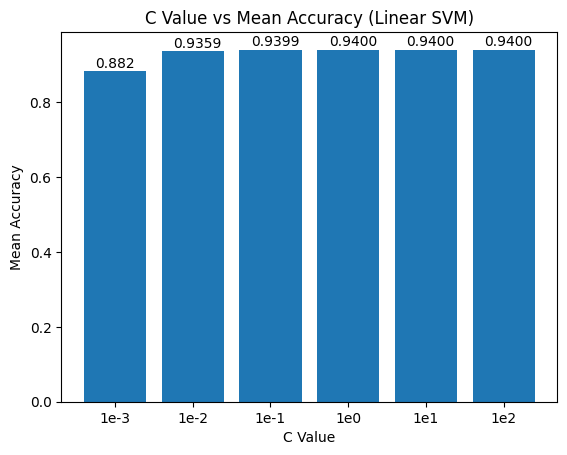

In [24]:
c_names = ["1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
plot_mean_acc_linear(c_names, accuracies_linear)

Accuracy is: 0.9899497487437185
Precision is: 0.9565217391304348
Recall is: 1.0
F1 Score is: 0.9777777777777777
F2 Score is: 0.990990990990991


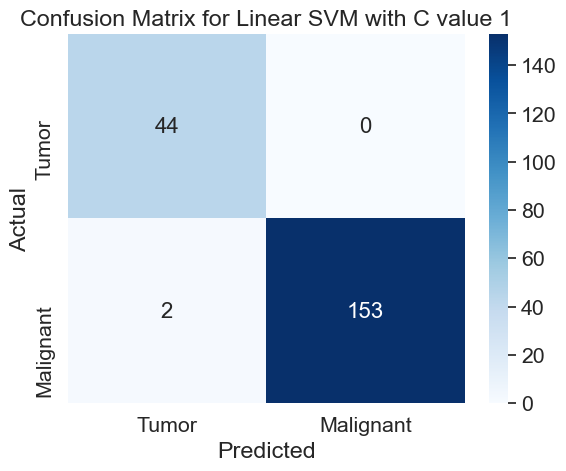

In [27]:
SVM_linear_model = linear_SVM(train_data.values, 1e0)
analyze_model(SVM_linear_model, test_data.values, "Linear SVM with C value 1")

In [28]:
def kernel_SVM(data, gamma_value):
    features = data[:,:8]
    labels = data[:,8]
    SVM = svm.SVC(kernel="rbf", gamma=gamma_value, max_iter=10000, C=1e0)
    SVM.fit(features, labels)
    return SVM

In [29]:
# Apply k fold cross validation for k=10 folds - Linear SVM
def cross_validation_kernel_SVM(data, fold_count, gamma_values):
    
    folds = generate_folds(data, 10)
    accuracies = [0] * (len(gamma_values))

    for i in range(fold_count):

        current_fold = folds[i]
        current_kept = current_fold[0]
        current_left = current_fold[1]

        for j, gamma_value in enumerate(gamma_values):

            SVM_model = kernel_SVM(current_kept, gamma_value)

            test_features = current_left[:,:8]
            test_labels = current_left[:,8]

            predictions = SVM_model.predict(test_features)

            # Calculate the prediction situation
            prediction_situation = predictions == test_labels
            num_true_predictions = np.count_nonzero(prediction_situation == True)
            num_predictions = len(prediction_situation)
            accuracy = num_true_predictions / num_predictions

            accuracies[j] += accuracy

    for j in range(len(accuracies)):
        accuracies[j] /= 10

    return accuracies


In [30]:
fold_count = 10
gamma_values = [2**(-4), 2**(-3), 2**(-2), 1, 2]
accuracies_kernel = cross_validation_kernel_SVM(data, fold_count, gamma_values)
accuracies_kernel

[0.9400000000000002, 0.9440000000000002, 0.932, 0.858, 0.7940000000000002]

In [31]:
def plot_mean_acc_kernel(gamma_names, accuracy_values):
    plt.style.use('default')
    plt.bar(gamma_names, accuracy_values)
    plt.xlabel("Gamma Value")
    plt.ylabel("Mean Accuracy")
    plt.title("Gamma Value vs Mean Accuracy (RBF Kernel SVM)")
    xlocs, xlabs = plt.xticks()
    for i, v in enumerate(accuracy_values):
        plt.text(xlocs[i] - 0.25, v + 0.01, str(v)[:6])
    plt.show()

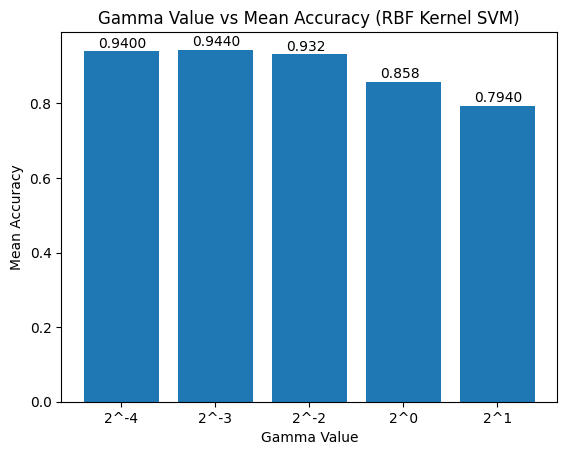

In [32]:
gamma_names = ["2^-4", "2^-3", "2^-2", "2^0", "2^1"]
plot_mean_acc_kernel(gamma_names, accuracies_kernel)

Optimum gamma is chosen as 2^-3

Accuracy is: 0.9849246231155779
Precision is: 0.9361702127659575
Recall is: 1.0
F1 Score is: 0.967032967032967
F2 Score is: 0.9865470852017937


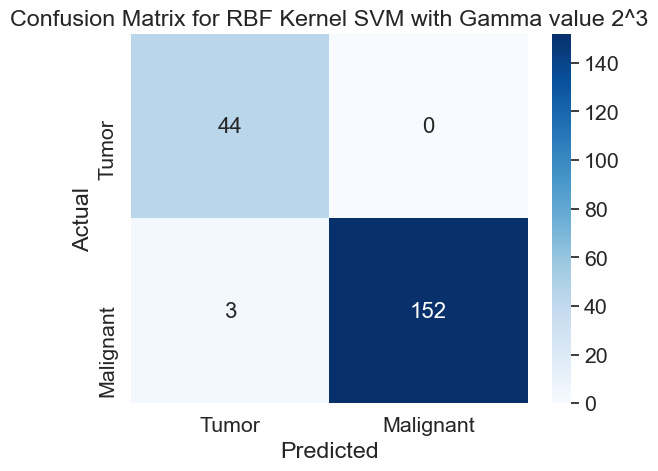

In [33]:
SVM_kernel_model = kernel_SVM(train_data.values, 2**(-3))
analyze_model(SVM_kernel_model, test_data.values, "RBF Kernel SVM with Gamma value 2^3")